This is a demo script that trains the classical 2D U-Net, as proposed in [1], for mitochondria segmentation in volume electron microscopy data. We also provide an implementation of the 3D variant, as proposed in [2]. 

1. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. Lecture Notes in Computer Science (Including Subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 9351, 234–241. https://doi.org/10.1007/978-3-319-24574-4_28
2. Çiçek, Ö., Abdulkadir, A., Lienkamp, S. S., Brox, T., & Ronneberger, O. (2016). 3D U-net: Learning dense volumetric segmentation from sparse annotation. In Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics) (Vol. 9901 LNCS, pp. 424–432). https://doi.org/10.1007/978-3-319-46723-8_49

Let's start with importing the required packages. 

In [1]:
%matplotlib inline
import os
import argparse
import datetime
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from data.datasets import StronglyLabeledVolumeDataset
from networks.unet import UNet2D, UNet3D
from util.io import imwrite3D
from util.losses import CrossEntropyLoss
from util.preprocessing import get_augmenters_2d, get_augmenters_3d
from util.validation import segment
from util.metrics import jaccard, dice, accuracy_metrics
from util.tools import overlay

Let's start by loading the data and a quick visualisation! 

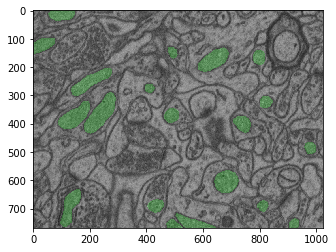

In [2]:
data_train = "../data/epfl/training.tif"
labels_train = "../data/epfl/training_groundtruth.tif"
data_test = "../data/epfl/testing.tif"
labels_test = "../data/epfl/testing_groundtruth.tif"

input_shape = (1, 128, 128)

train_xtransform, train_ytransform, test_xtransform, test_ytransform = get_augmenters_2d()

train = StronglyLabeledVolumeDataset(data_train, labels_train, input_shape, transform=train_xtransform, target_transform=train_ytransform, preprocess='unit')
test = StronglyLabeledVolumeDataset(data_test, labels_test, input_shape, transform=test_xtransform, target_transform=test_ytransform, preprocess='unit')

plt.imshow(overlay(test.data[0,...],test.labels[0,...], alpha=0.2))

Right. Now let's put this data in a dataloader for easy use in PyTorch. We will use a batch size of 4 for training and testing. You can make this smaller or larger depending on your computational resources. 

In [3]:
batch_size = 4

train_loader = DataLoader(train, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

We are now ready to define and train the network! For computational simplicity, we will use a slightly smaller version of the original U-Net. We will train the network with cross entropy loss for 10 epochs with learning rate of 0.01 with multiplicative decay (decay factor 0.9) every epoch. We will test the network after every epoch and print out some logging statistics every 50 iterations. 

In [4]:
net = UNet2D(feature_maps=16)

loss_fn = CrossEntropyLoss()
lr = 1e-2
step_size = 1
gamma = 0.9
epochs = 10
test_freq = 1
print_stats = 50
log_dir = "logs"

net.train_net(train_loader=train_loader, test_loader=test_loader,
              loss_fn=loss_fn, lr=lr, step_size=step_size, gamma=gamma,
              epochs=epochs, test_freq=test_freq, print_stats=print_stats,
              log_dir=log_dir)

[2019-02-14 13:21:21.652842] Epoch     0/   10
[2019-02-14 13:21:23.021628] Epoch     0 - Iteration     0/  250 - Loss: 0.835338
[2019-02-14 13:21:26.464342] Epoch     0 - Iteration    50/  250 - Loss: 0.055801
[2019-02-14 13:21:30.071957] Epoch     0 - Iteration   100/  250 - Loss: 0.106639
[2019-02-14 13:21:33.706556] Epoch     0 - Iteration   150/  250 - Loss: 0.088007
[2019-02-14 13:21:37.378801] Epoch     0 - Iteration   200/  250 - Loss: 0.082968
[2019-02-14 13:21:40.888462] Epoch     0 - Average train loss: 0.160754
[2019-02-14 13:21:44.378210] Epoch     0 - Average test loss: 0.131203
[2019-02-14 13:21:44.483144] Epoch     1/   10
[2019-02-14 13:21:44.556644] Epoch     1 - Iteration     0/  250 - Loss: 0.105185
[2019-02-14 13:21:48.213477] Epoch     1 - Iteration    50/  250 - Loss: 0.090711
[2019-02-14 13:21:51.962583] Epoch     1 - Iteration   100/  250 - Loss: 0.065554
[2019-02-14 13:21:55.476892] Epoch     1 - Iteration   150/  250 - Loss: 0.102833
[2019-02-14 13:21:59.0047

Great! Let's segment the first slice of our test dataset and validate it! 

Validation results:
     Jaccard: 0.765045
     Dice: 0.866885
     Accuracy: 0.979865
     Precision: 0.935992
     Recall: 0.807280
     F-score: 0.866885


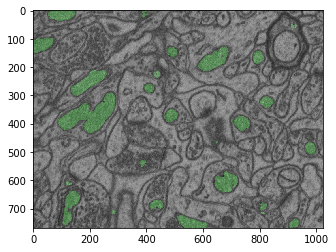

In [5]:
test_data = test.data[0:1,...]
test_labels = test.labels[0:1,...]
segmentation = segment(test_data, net, (128, 128), batch_size=batch_size)

plt.imshow(overlay(test_data[0, ...], segmentation[0, ...]>0.5, alpha=0.2))

j = jaccard(segmentation, test_labels)
d = dice(segmentation, test_labels)
a, p, r, f = accuracy_metrics(segmentation, test_labels)
print('Validation results:')
print('     Jaccard: %f' % (j))
print('     Dice: %f' % (d))
print('     Accuracy: %f' % (a))
print('     Precision: %f' % (p))
print('     Recall: %f' % (r))
print('     F-score: %f' % (f))

Of course the results can be improved significantly by increasing the capacity of the network and tuning the hyperparameters. 